# Relation of schooling years to education

In this notebook we will analyze the correlation between years of education and the proficiency in certain skills.

First we will load all the data and extract the relevant indicators (see notebook `11` for details):

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import edstats_utils as edstats
%matplotlib inline

# some pandas options
pd.set_option('display.max_colwidth', -1)

# load the relevant data
datapath = "./datasets/edstats"
df_country = pd.read_csv(os.path.join(datapath, "EdStatsCountry.csv"))
df_data = pd.read_csv(os.path.join(datapath, "EdStatsData.csv"))
df_series = pd.read_csv(os.path.join(datapath, "EdStatsSeries.csv"))
df_note = pd.read_csv(os.path.join(datapath, "EdStatsFootNote.csv"))
df_cseries = pd.read_csv(os.path.join(datapath, "EdStatsCountry-Series.csv"))

Now we are using the extraction functions defined in `edstats` to extract the relevant data we are going to need

In [2]:
# retrieve the proficiency skills
df_adult_prof = edstats.retrieve_skill_piaac(df_data)
df_pisa = edstats.retrieve_skill_pisa(df_data)
df_stud_bm = edstats.retrieve_skill_timss(df_data)
df_stud_prof = edstats.retrieve_skill_llece(df_data)

# retrieve the data for mean schooling years
df_wp_meanschool = edstats.retrieve_wittgenstein_mean_schooling(df_data)
df_bl_eduperc = edstats.retrieve_barrolee_percentage(df_data)
df_bl_eduyears = edstats.retrieve_barrolee_years(df_data)
df_ed_years = edstats.retrieve_education_length(df_data)

We are using different indicators, however the first step will be to identify, which provides the best data source.

## Which skills to use

Let us first take a look at the skill data. The main questions we want to answer:

* What is the coverage of the data across countries and years?
* Which skills do we have?
* Can we identify certain trends regarding the skills?


In [3]:
# find the years available for the indicators
print(df_adult_prof.dropna(axis=1, how='all').columns)
print(df_pisa.dropna(axis=1, how='all').columns)
print(df_stud_bm.dropna(axis=1, how='all').columns)
print(df_stud_prof.dropna(axis=1, how='all').columns)

ls = [
    ('PIAAC', ['2012', '2015'], df_adult_prof), 
    ("PISA", ['2000', '2003', '2006', '2009', '2012', '2015'], df_pisa), 
    ('TIMSS', ['1995', '1999', '2003', '2007', '2011', '2015'], df_stud_bm),
    ('LLECE', ['2006', '2013'], df_stud_prof)
]

# find the number of countries for each indicator
for nm, yrs, df in ls:
    print("\n{} Countries for subjects:".format(nm))
    print("-"*30)
    print(df[df[yrs].isnull().min(axis=1) == False].groupby(['Indicator Name', 'subject']).count().groupby('subject').max()[yrs])

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '2012', '2015', 'indicator', 'gender', 'subject', 'level'],
      dtype='object')
Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '2000', '2003', '2006', '2009', '2012', '2015', 'indicator', 'gender',
       'subject', 'level'],
      dtype='object')
Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1995', '1999', '2003', '2007', '2011', '2015', 'indicator', 'gender',
       'subject', 'achievement'],
      dtype='object')
Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '2006', '2013', 'indicator', 'gender', 'grade', 'subject', 'level'],
      dtype='object')

PIAAC Countries for subjects:
------------------------------
                                                 2012  2015
subject                                                    
literacy                                         22    8   
numeracy 

We can see that the global coverage is quite low, with the adult proficiency score only having 22 countries and the Pisa Scores being available for only 71 countries in 2015. We also see a strong variance across the years. For the current question I will use the PIAAC (`df_adult_prof`) data, as we want to check how different years of education change the proficiency in certain skills of the entire population.

Next lets visualize the data over the years:

In [4]:
# clean the dataset and add the region
ls_adult_years = ['2012', '2015']
df_adpr_clean = edstats.filter_years(df_adult_prof, ls_adult_years).dropna(axis=1, how='all')
df_adpr_clean = df_adpr_clean[df_adpr_clean.iloc[:, 4:6].isnull().min(axis=1) == False]
df_adpr_clean = edstats.append_region(df_adpr_clean, df_country)

In [5]:
# show data points across the different regions
#df_adpr_clean
df_adpr_clean[(df_adpr_clean['gender'] == 'Total')]\
    .groupby(['subject', 'level', 'Region']).count()[ls_adult_years]\
    .groupby(['subject', 'Region']).max()\
    .style.background_gradient(cmap='viridis')

In [32]:
df_adpr_clean['Country Name'].unique()

array(['Australia', 'Austria', 'Canada', 'Chile', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Korea, Rep.', 'Lithuania', 'Netherlands', 'New Zealand', 'Norway',
       'Poland', 'Russian Federation', 'Singapore', 'Slovak Republic',
       'Slovenia', 'Spain', 'Sweden', 'Turkey', 'United States'],
      dtype=object)

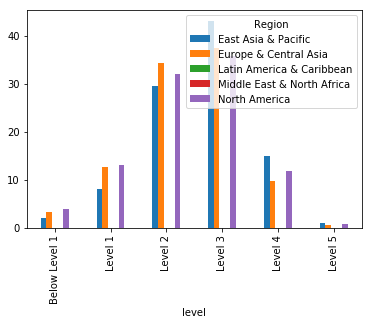

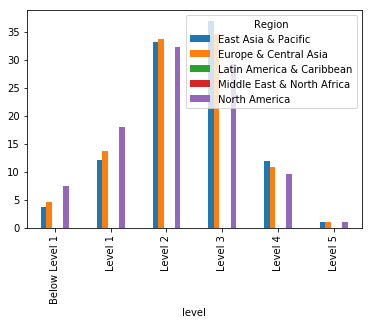

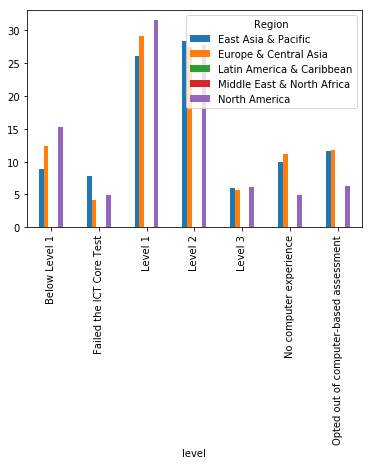

In [33]:
#tmp = df_pisa_clean[(df_pisa_clean['gender'] == 'Total') & (df_pisa_clean['subject'] == 'literacy')].groupby(['level', 'Region']).mean()[['2015']]
#tmp = tmp.reset_index().groupby('Region', axis=1).mean().groupby('level', axis=1).mean()#.transpose()
for sub in ['literacy', 'numeracy', 'problem solving in technology-rich environments']:
    tmp = df_adpr_clean[(df_adpr_clean['gender'] == 'Total') & (df_adpr_clean['subject'] == sub)][['Country Name', 'Region', 'level', '2012']]
    tmp.groupby(['Region', 'level']).mean().reset_index().pivot(index='level', columns='Region', values='2012').plot.bar();

#tmp#.plot.bar(figsize=(20, 15))

Unfortunatly, the data we have is quite sparse.